In [1]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
path = 'Resources/Data_ElectricPe.xlsx'
data = pd.read_excel(path)
data.head()

,StationID,Station_Name,Station_Type,Station_Category,Station_Access,ChargerID,Ping_Date,hour0,hour1,hour2,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-25,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-26,True,True,True,...,False,False,False,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-27,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-28,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-29,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22530 entries, 0 to 22529
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   StationID         22530 non-null  object        
 1   Station_Name      22530 non-null  object        
 2   Station_Type      22530 non-null  object        
 3   Station_Category  22530 non-null  object        
 4   Station_Access    22530 non-null  object        
 5   ChargerID         22530 non-null  object        
 6   Ping_Date         22530 non-null  datetime64[ns]
 7   hour0             22530 non-null  bool          
 8   hour1             22530 non-null  bool          
 9   hour2             22530 non-null  bool          
 10  hour3             22530 non-null  bool          
 11  hour4             22530 non-null  bool          
 12  hour5             22530 non-null  bool          
 13  hour6             22530 non-null  bool          
 14  hour7             2253

In [4]:
print(f"Dataset contains {len(data)} rows.")

Dataset contains 22530 rows.


In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Drop rows with missing values
data_cleaned = data.dropna()
print(f"Data after cleaning: {len(data_cleaned)} rows remain.")

Missing values:
 hour17    3755
hour18    3755
hour19    3755
hour20    3755
hour21    3755
hour22    3755
hour23    3755
dtype: int64
Data after cleaning: 18775 rows remain.


In [6]:
# Identifying categorical columns and their unique value counts
categorical_columns = data_cleaned.select_dtypes(include=['object', 'bool']).columns
unique_value_counts = {col: data_cleaned[col].nunique() for col in categorical_columns}

unique_value_counts


{'StationID': 1903,
 'Station_Name': 1892,
 'Station_Type': 1,
 'Station_Category': 11,
 'Station_Access': 3,
 'ChargerID': 3755,
 'hour0': 2,
 'hour1': 2,
 'hour2': 2,
 'hour3': 2,
 'hour4': 2,
 'hour5': 2,
 'hour6': 2,
 'hour7': 2,
 'hour8': 2,
 'hour9': 2,
 'hour10': 2,
 'hour11': 2,
 'hour12': 2,
 'hour13': 2,
 'hour14': 2,
 'hour15': 2,
 'hour16': 2}

In [7]:
len(data_cleaned)

18775

In [8]:
# Initialize encoders
onehot_encoder = OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

# Applying One-Hot Encoding
onehot_encoded_columns = ['Station_Access', 'Station_Category'] + [f'hour{i}' for i in range(17)]
data_onehot_encoded = pd.get_dummies(data_cleaned, columns=onehot_encoded_columns)

# Applying Label Encoding
for col in ['StationID', 'Station_Name', 'ChargerID']:
    data_onehot_encoded[col] = label_encoder.fit_transform(data_onehot_encoded[col])

# Drop 'Station_Type' if it has only one unique value
if data_onehot_encoded['Station_Type'].nunique() == 1:
    data_onehot_encoded.drop('Station_Type', axis=1, inplace=True)

# Display the transformed dataset
data_onehot_encoded.head()


,StationID,Station_Name,ChargerID,Ping_Date,hour17,hour18,hour19,hour20,hour21,hour22,...,hour12_False,hour12_True,hour13_False,hour13_True,hour14_False,hour14_True,hour15_False,hour15_True,hour16_False,hour16_True
0,0,1469,3572,2023-11-25,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True
1,0,1469,3572,2023-11-26,0.0,0.0,0.0,1.0,1.0,1.0,...,True,False,True,False,True,False,True,False,True,False
2,0,1469,3572,2023-11-27,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True
3,0,1469,3572,2023-11-28,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True
4,0,1469,3572,2023-11-29,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True


In [9]:
# Initialize the Min-Max Scaler
min_max_scaler = MinMaxScaler()

# Identifying numerical columns (excluding encoded categorical columns)
numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Applying Min-Max Scaling to the numerical columns
data_normalized = data_onehot_encoded.copy()
data_normalized[numerical_columns] = min_max_scaler.fit_transform(data_normalized[numerical_columns])

# Display the first few rows of the normalized dataset
data_normalized.head()


,StationID,Station_Name,ChargerID,Ping_Date,hour17,hour18,hour19,hour20,hour21,hour22,...,hour12_False,hour12_True,hour13_False,hour13_True,hour14_False,hour14_True,hour15_False,hour15_True,hour16_False,hour16_True
0,0,1469,3572,2023-11-25,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True
1,0,1469,3572,2023-11-26,0.0,0.0,0.0,1.0,1.0,1.0,...,True,False,True,False,True,False,True,False,True,False
2,0,1469,3572,2023-11-27,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True
3,0,1469,3572,2023-11-28,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True
4,0,1469,3572,2023-11-29,1.0,1.0,1.0,1.0,1.0,1.0,...,False,True,False,True,False,True,False,True,False,True


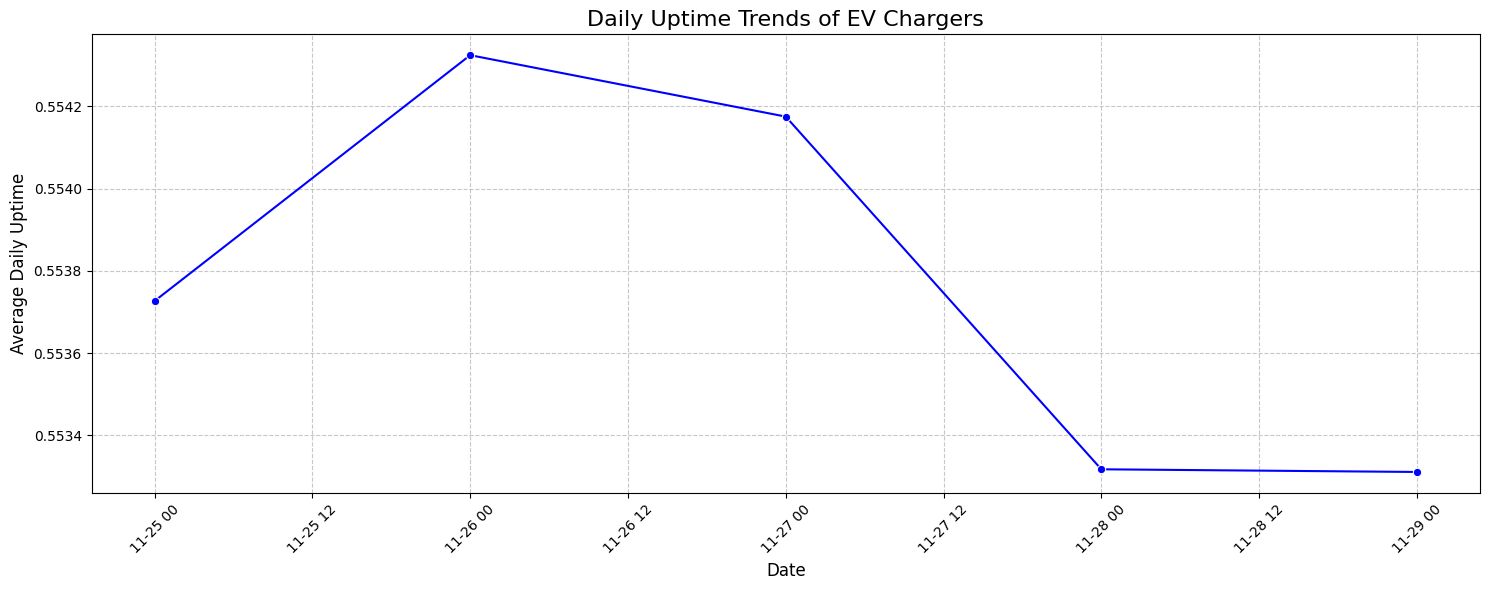

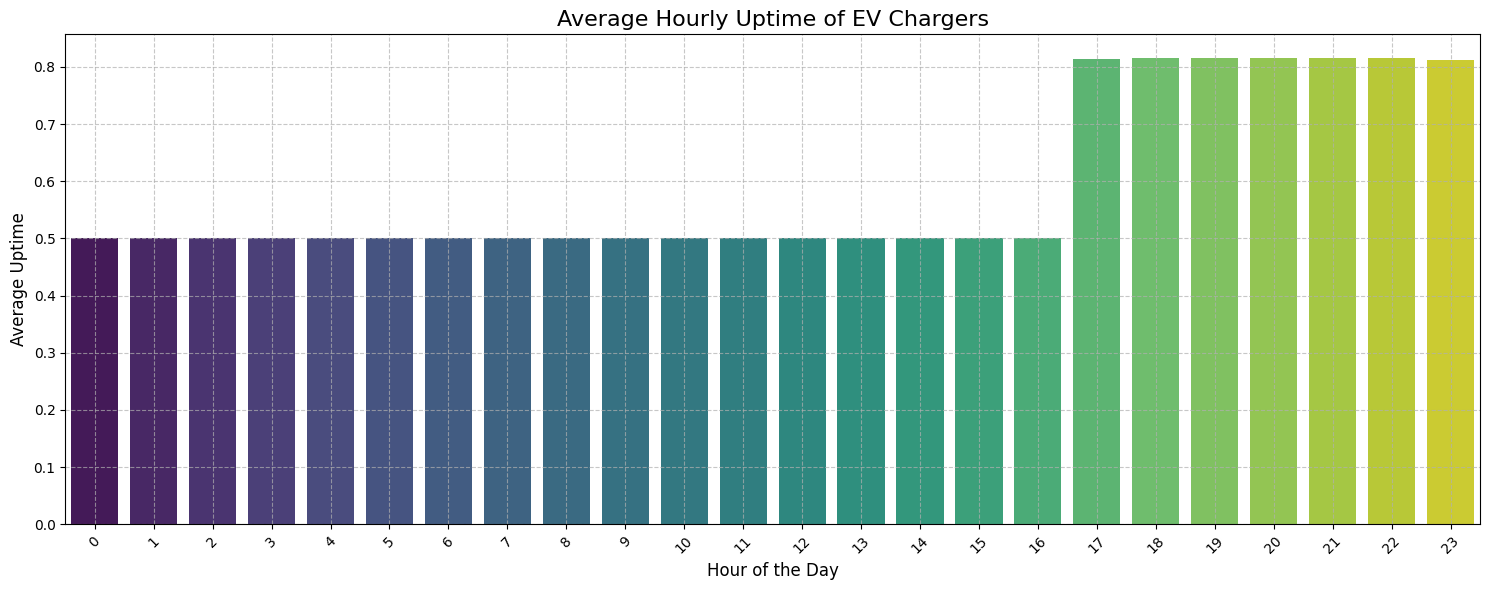

In [10]:
# Preparing the dataset for daily and hourly analysis
# Extracting only the hour columns for uptime analysis
# Extracting uptime columns and adding 'Ping_Date' for grouping
uptime_columns = [col for col in data_normalized.columns if 'hour' in col]
uptime_data = data_normalized[['Ping_Date'] + uptime_columns]

# Daily Uptime Analysis
daily_uptime = uptime_data.groupby('Ping_Date')[uptime_columns].mean()

# Plotting daily uptime trends
plt.figure(figsize=(15, 6))
sns.lineplot(data=daily_uptime.mean(axis=1), marker="o", color='blue')
plt.title('Daily Uptime Trends of EV Chargers', fontsize=16)
plt.ylabel('Average Daily Uptime', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Hourly Uptime Analysis
# Reshape data for hourly analysis
hourly_uptime = uptime_data.melt(id_vars=['Ping_Date'], var_name='Hour', value_name='Uptime')
hourly_uptime['Hour'] = hourly_uptime['Hour'].str.extract(r'(\d+)').astype(int)  # Extract hour number as int
hourly_avg_uptime = hourly_uptime.groupby('Hour')['Uptime'].mean()

# Plotting hourly uptime trends
plt.figure(figsize=(15, 6))
sns.barplot(x=hourly_avg_uptime.index, y=hourly_avg_uptime.values, palette="viridis")
plt.title('Average Hourly Uptime of EV Chargers', fontsize=16)
plt.ylabel('Average Uptime', fontsize=12)
plt.xlabel('Hour of the Day', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Using the original cleaned dataset for station uptime analysis
station_uptime_original = data_cleaned.copy()
uptime_columns = [col for col in data_normalized.columns if 'hour' in col and '_False' not in col and '_True' not in col]
station_uptime_original['Average_Uptime'] = station_uptime_original[uptime_columns].mean(axis=1)
station_average_uptime_original = station_uptime_original.groupby(['StationID', 'Station_Name'])['Average_Uptime'].mean()

# Identifying High and Low Performing Stations in the original dataset
high_performing_stations_original = station_average_uptime_original.sort_values(ascending=False).head(10)
low_performing_stations_original = station_average_uptime_original.sort_values(ascending=True).head(10)

# Displaying the high and low performing stations from the original dataset
print("High Performing Stations:\n", high_performing_stations_original )
print("Low Performing Stations:\n", low_performing_stations_original)

High Performing Stations:
 StationID                 Station_Name            
62ea9020d792403eff3276ac  SRI KRUPA                   1.0
632ecf59908c4b1e744a8191  SARANYA HOMES               1.0
63309cdd5f59893aad8092b1  SRI TIRUMALA AMBIENCE       1.0
633038ce1a9965657177c4b5  GALAXY APARTMENT            1.0
633037ad1a9965657177c4aa  MALAVIRAA ENCLAVE           1.0
633037491a9965657177c4a9  SNEHITHA HOUSE              1.0
63302b421a9965657177c419  D K RESIDENCY               1.0
63302ad61a9965657177c417  KWALITY RAAGA APARTMENTS    1.0
632ef41a908c4b1e744a824a  RUTHU RESIDENCY             1.0
632ed430908c4b1e744a819d  SRINIDHI KRISHNA            1.0
Name: Average_Uptime, dtype: float64
Low Performing Stations:
 StationID                             Station_Name             
534cea04-32b5-419e-a4d8-c30e1dd7ae3d  Sharanya Arcade Apartment    0.0
62bc4d10bc00ac3d4cbc12f5              KHUSHI HOMES 1               0.0
62bc8bfebc00ac3d4c01c72a              Uphaar kushi home 2          0.0
62

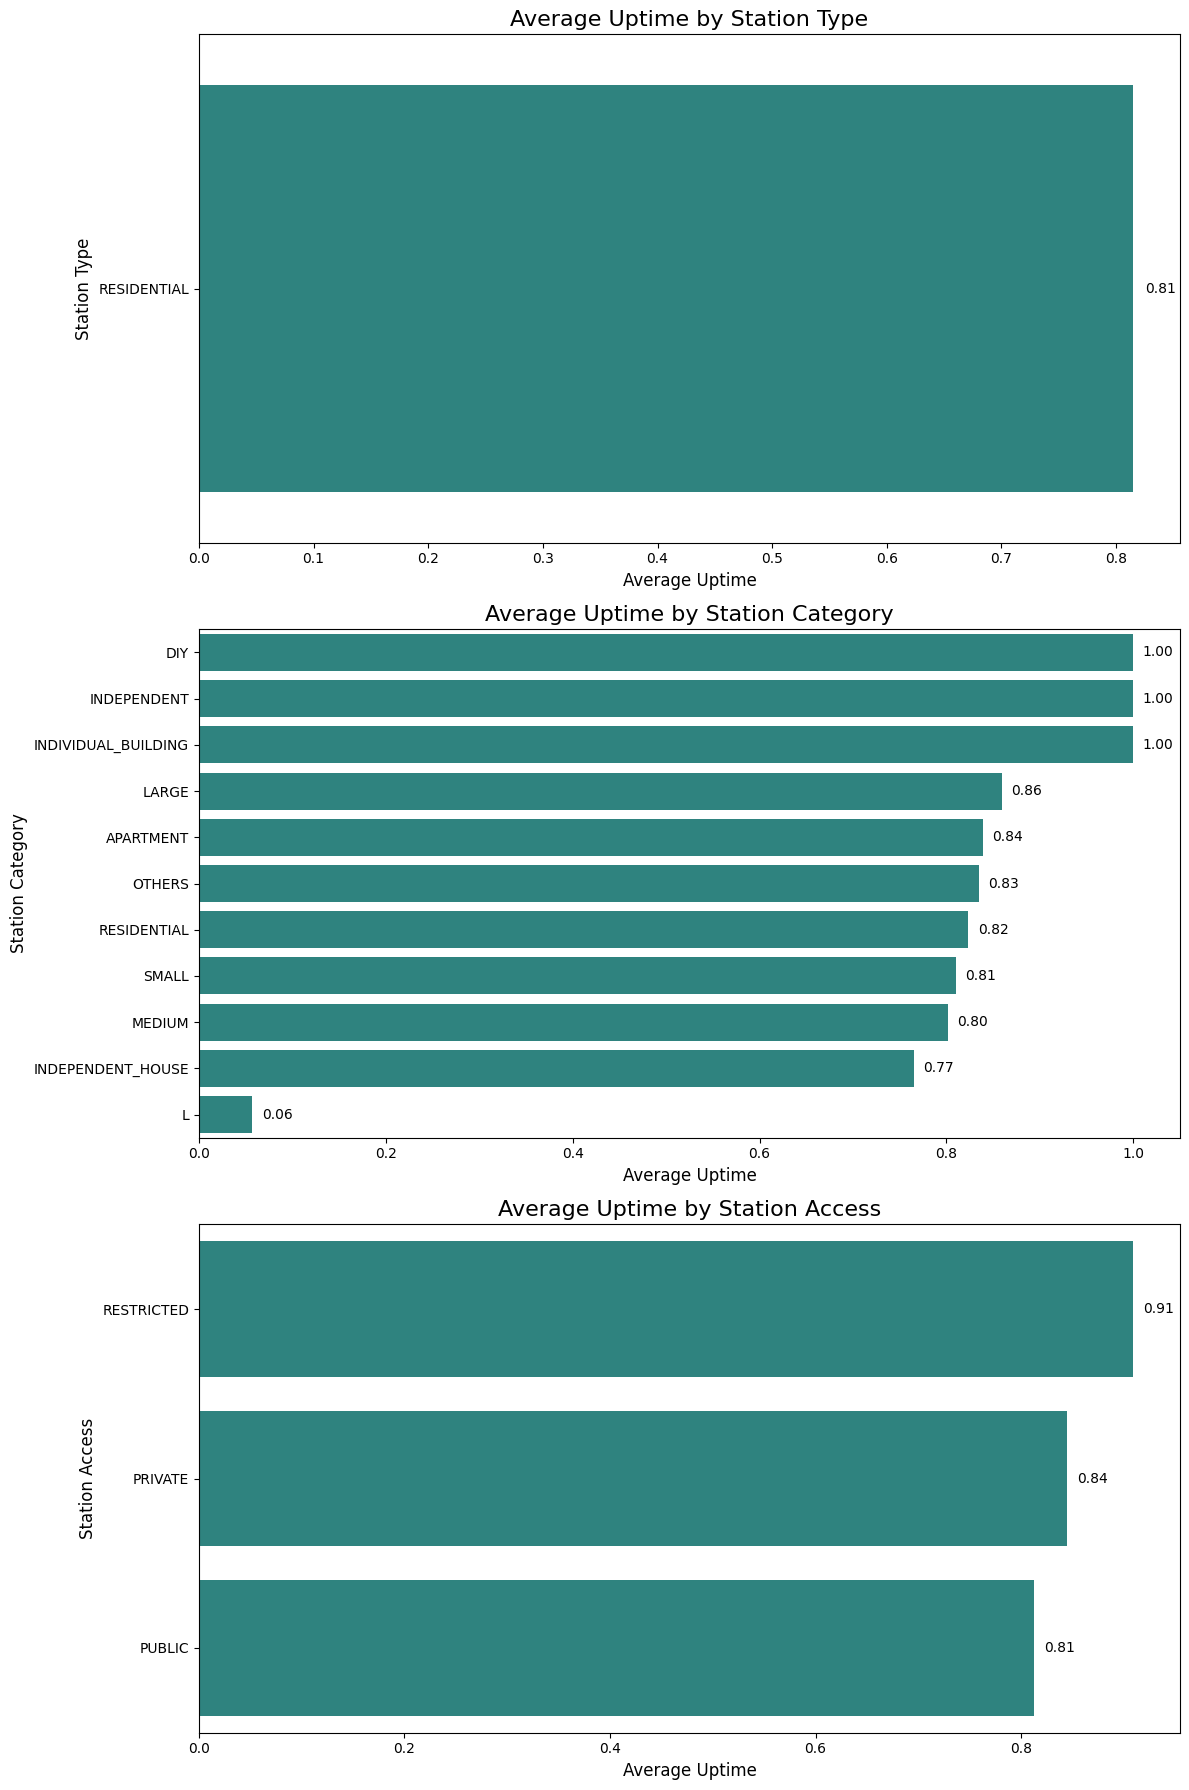

In [12]:
# Preparing the dataset for analysis based on station characteristics
station_char_uptime = data_cleaned.copy()
station_char_uptime['Average_Uptime'] = station_char_uptime[uptime_columns].mean(axis=1)

# Aggregating average uptime by station characteristics
uptime_by_type = station_char_uptime.groupby('Station_Type')['Average_Uptime'].mean()
uptime_by_category = station_char_uptime.groupby('Station_Category')['Average_Uptime'].mean()
uptime_by_access = station_char_uptime.groupby('Station_Access')['Average_Uptime'].mean()

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Define a color palette
palette = sns.color_palette("viridis", len(uptime_by_type))

# Uptime by Station Type
uptime_by_type = uptime_by_type.sort_values(ascending=False)
sns.barplot(x=uptime_by_type.values, y=uptime_by_type.index, ax=axes[0], palette=palette)
axes[0].set_title('Average Uptime by Station Type', fontsize=16)
axes[0].set_xlabel('Average Uptime', fontsize=12)
axes[0].set_ylabel('Station Type', fontsize=12)
for i, v in enumerate(uptime_by_type.values):
    axes[0].text(v + 0.01, i, f'{v:.2f}', va='center')

# Uptime by Station Category
uptime_by_category = uptime_by_category.sort_values(ascending=False)
sns.barplot(x=uptime_by_category.values, y=uptime_by_category.index, ax=axes[1], palette=palette)
axes[1].set_title('Average Uptime by Station Category', fontsize=16)
axes[1].set_xlabel('Average Uptime', fontsize=12)
axes[1].set_ylabel('Station Category', fontsize=12)
for i, v in enumerate(uptime_by_category.values):
    axes[1].text(v + 0.01, i, f'{v:.2f}', va='center')

# Uptime by Station Access
uptime_by_access = uptime_by_access.sort_values(ascending=False)
sns.barplot(x=uptime_by_access.values, y=uptime_by_access.index, ax=axes[2], palette=palette)
axes[2].set_title('Average Uptime by Station Access', fontsize=16)
axes[2].set_xlabel('Average Uptime', fontsize=12)
axes[2].set_ylabel('Station Access', fontsize=12)
for i, v in enumerate(uptime_by_access.values):
    axes[2].text(v + 0.01, i, f'{v:.2f}', va='center')

# Add tight layout
plt.tight_layout()
plt.show()

In [13]:
# Preparing data for ANOVA tests
uptime_anova = data_cleaned.copy()
uptime_anova['Average_Uptime'] = uptime_anova[uptime_columns].mean(axis=1)


# ANOVA for Station Category
anova_category = stats.f_oneway(*[group["Average_Uptime"].values for name, group in uptime_anova.groupby("Station_Category")])

# ANOVA for Station Access
anova_access = stats.f_oneway(*[group["Average_Uptime"].values for name, group in uptime_anova.groupby("Station_Access")])

print(f"ANOVA p-value for Station Category: {anova_category.pvalue}")
print(f"ANOVA p-value for Station Access: {anova_access.pvalue}")


ANOVA p-value for Station Category: 2.0383598385392755e-10
ANOVA p-value for Station Access: 0.0006126614696092441


In [14]:
# Finding a charger station with a good balance of uptime and downtime
charger_uptime_balanced = data_cleaned[uptime_columns + ['ChargerID']].copy()
charger_uptime_balanced['Daily_Average_Uptime'] = charger_uptime_balanced[uptime_columns].mean(axis=1)

# Calculating the overall average uptime for each charger
average_uptime_per_charger = charger_uptime_balanced.groupby('ChargerID')['Daily_Average_Uptime'].mean()

# Selecting a charger with a balance of uptime and downtime (average uptime around 0.5)
balanced_chargers = average_uptime_per_charger[average_uptime_per_charger.between(0.4, 0.6)]
selected_charger = balanced_chargers.sample(1).index[0]

selected_charger, balanced_chargers[selected_charger]


('WA000121LAC1S000458_v3', 0.5714285714285714)

In [54]:
# Filtering the data for the selected charger station
selected_charger_data = data_cleaned[data_cleaned['ChargerID'] == selected_charger]

# Creating a time series dataset with daily records
selected_charger_daily = selected_charger_data[['Ping_Date'] + uptime_columns]
selected_charger_daily = selected_charger_daily.set_index('Ping_Date')
selected_charger_daily['Daily_Average_Uptime'] = selected_charger_daily.mean(axis=1)

# Generating lag features (previous day's uptime)
selected_charger_daily['Lag_1'] = selected_charger_daily['Daily_Average_Uptime'].shift(1)

# Dropping the first row as it now has NaN values due to the lag feature
selected_charger_daily.dropna(inplace=True)
# selected_charger_daily.fillna(0, inplace=True)

# Displaying the prepared time series data
selected_charger_daily.head()


,hour17,hour18,hour19,hour20,hour21,hour22,hour23,Daily_Average_Uptime,Lag_1
Ping_Date,,,,,,,,,
2023-11-26,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.857143,1.000000
2023-11-27,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.857143
2023-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2023-11-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [30]:
# Add rolling averages
selected_charger_daily['Rolling_Mean_3'] = selected_charger_daily['Daily_Average_Uptime'].rolling(3).mean()
selected_charger_daily['Rolling_Mean_7'] = selected_charger_daily['Daily_Average_Uptime'].rolling(7).mean()

# Add more lag features
selected_charger_daily['Lag_2'] = selected_charger_daily['Daily_Average_Uptime'].shift(2)
selected_charger_daily['Lag_3'] = selected_charger_daily['Daily_Average_Uptime'].shift(3)

# Impute nulls with 0s
selected_charger_daily.fillna(0, inplace=True)

X = selected_charger_daily[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_7']]

In [49]:
print(X.columns)

Index(['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_7'], dtype='object')


In [32]:
# Preparing the data for the model
#X = selected_charger_daily[['Lag_1']]  # Features (previous day's uptime)
y = selected_charger_daily['Daily_Average_Uptime']  # Target (current day's uptime)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Training a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rf_rmse}")

RMSE: 0.41285714285714287


In [33]:
# Forecasting the next day's uptime
# Using the last day's uptime in the dataset as the input for the prediction
last_day_uptime = X.iloc[-1].values.reshape(1, -1)
predicted_uptime = model.predict(last_day_uptime)[0]
print(f"Predicted Next Day Uptime: {predicted_uptime}")

Predicted Next Day Uptime: 0.41285714285714287


In [34]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and RMSE
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"RMSE after Tuning: {rmse}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END m

In [35]:
# Initialize and train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
y_pred = xgb_model.predict(X_test)
xgb_rmse= mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost RMSE: {xgb_rmse}")

XGBoost RMSE: 0.0029602646827697754


In [36]:
# Initialize and train LightGBM
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model.fit(X_train, y_train)

# Evaluate LightGBM
y_pred = lgbm_model.predict(X_test)
lgbm_rmse= mean_squared_error(y_test, y_pred, squared=False)
print(f"LightGBM RMSE: {lgbm_rmse}")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 3, number of used features: 0
[LightGBM] [Info] Start training from score 0.619048
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

In [37]:
# Initialize and train CatBoost
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=5, verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Evaluate CatBoost
y_pred = cat_model.predict(X_test)
cat_rmse= mean_squared_error(y_test, y_pred, squared=False)
print(f"CatBoost RMSE: {cat_rmse}")

CatBoost RMSE: 0.4132187400840676


In [38]:
# Initialize and train SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Evaluate SVR
y_pred = svr_model.predict(X_test)
svr_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"SVR RMSE: {svr_rmse}")

SVR RMSE: 0.27823387628385277


In [39]:
# Reshape data for LSTM input
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=1)

# Evaluate LSTM
y_pred = model.predict(X_test_lstm).flatten()
lstm_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"LSTM RMSE: {lstm_rmse}")

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.5613
Epoch 2/20
1/1 [==============================] - 0s 57ms/step - loss: 0.5557
Epoch 3/20
1/1 [==============================] - 0s 17ms/step - loss: 0.5500
Epoch 4/20
1/1 [==============================] - 0s 19ms/step - loss: 0.5446
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.5393
Epoch 6/20
1/1 [==============================] - 0s 15ms/step - loss: 0.5340
Epoch 7/20
1/1 [==============================] - 0s 19ms/step - loss: 0.5287
Epoch 8/20
1/1 [==============================] - 0s 17ms/step - loss: 0.5235
Epoch 9/20
1/1 [==============================] - 0s 42ms/step - loss: 0.5184
Epoch 10/20
1/1 [==============================] - 0s 20ms/step - loss: 0.5134
Epoch 11/20
1/1 [==============================] - 0s 15ms/step - loss: 0.5084
Epoch 12/20
1/1 [==============================] - 0s 17ms/step - loss: 0.5035
Epoch 13/20
1/1 [==============================] - 0s 17ms/step

In [40]:
results = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVR', 'LSTM'],
    'RMSE': [rf_rmse, xgb_rmse, lgbm_rmse, cat_rmse, svr_rmse, lstm_rmse]
}

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='RMSE'))

           Model      RMSE
1        XGBoost  0.002960
5           LSTM  0.013678
4            SVR  0.278234
0  Random Forest  0.412857
3       CatBoost  0.413219
2       LightGBM  0.619048


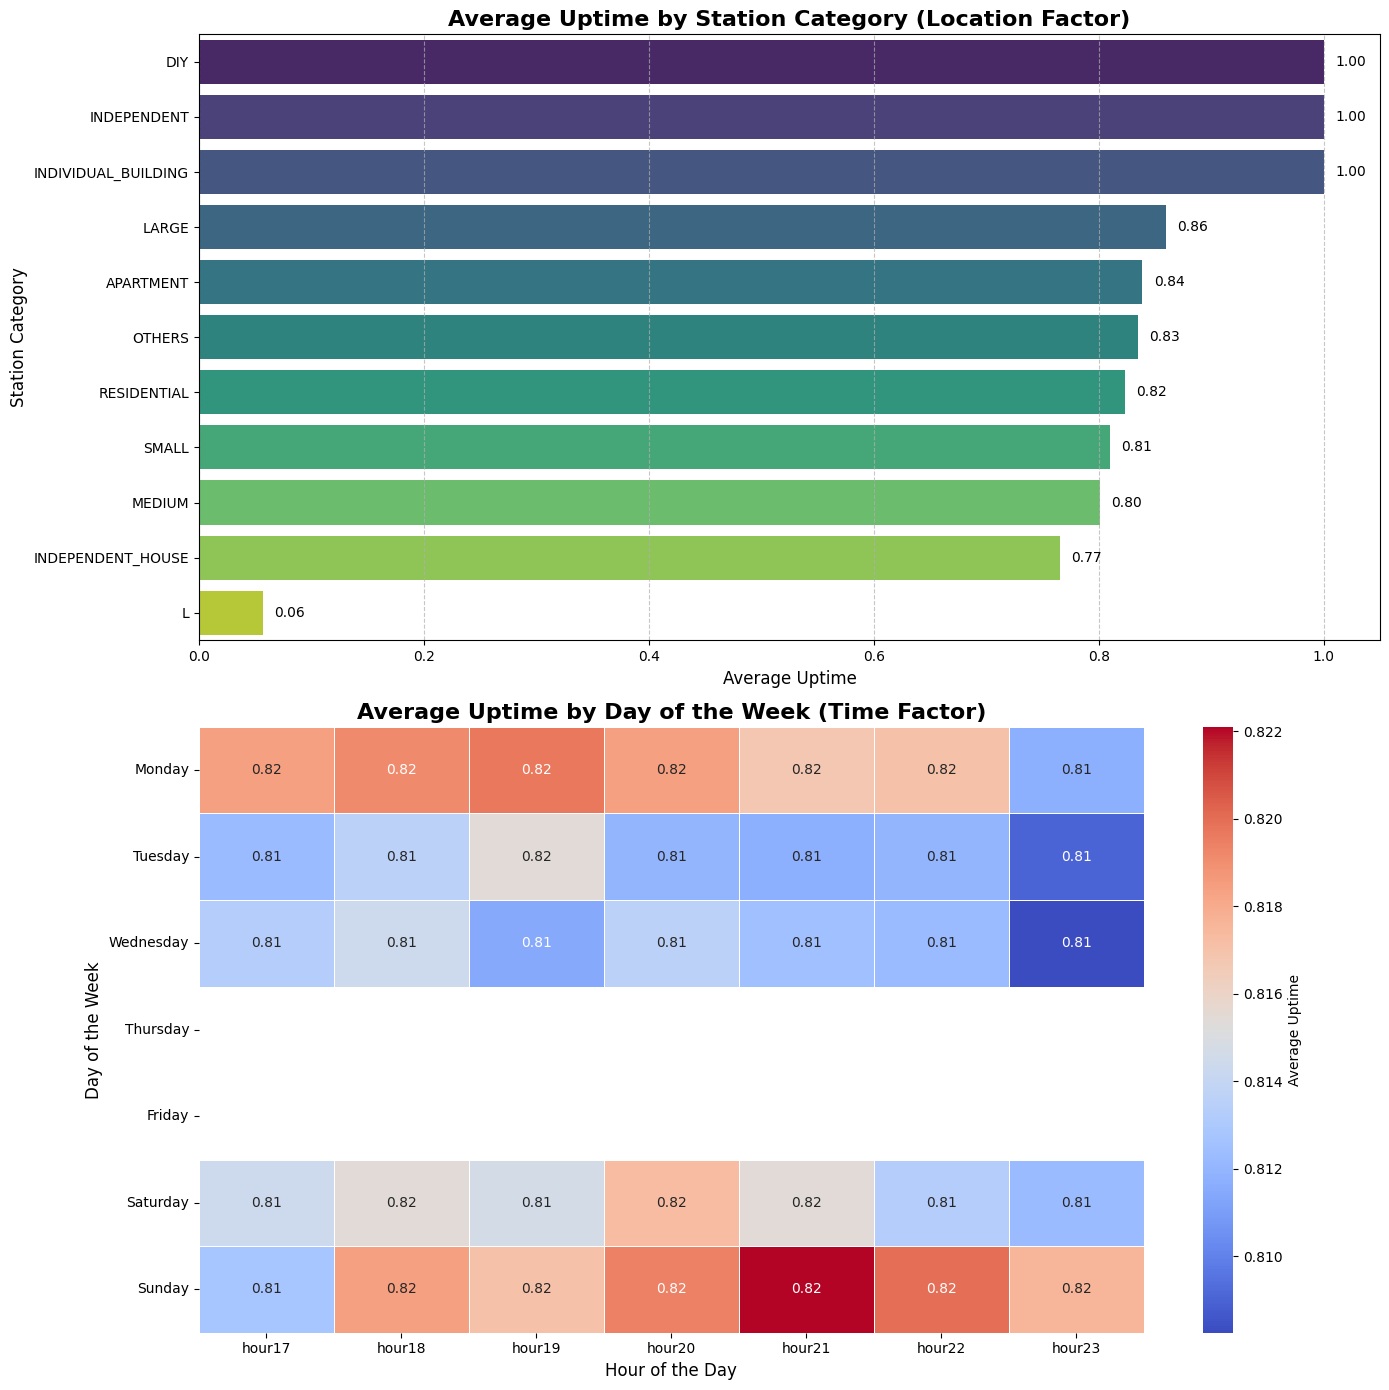

In [41]:
# Charger Location Factors Analysis
# We already have uptime by Station Category from a previous analysis. We'll revisit this with more focus on location implications
uptime_by_category_location = uptime_by_category

# Time-Based Patterns Analysis
# Extracting day of the week from the Ping_Date
data_cleaned['DayOfWeek'] = data_cleaned['Ping_Date'].dt.day_name()
uptime_by_day_of_week = data_cleaned.groupby('DayOfWeek')[uptime_columns].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Visualizations

fig, ax = plt.subplots(2, 1, figsize=(14, 14))

# Uptime by Station Category (Location Factor)
sns.barplot(
    x=uptime_by_category_location.values,
    y=uptime_by_category_location.index,
    ax=ax[0],
    palette="viridis"
)
# Add annotations
for i, value in enumerate(uptime_by_category_location.values):
    ax[0].text(value + 0.01, i, f"{value:.2f}", va="center", fontsize=10)
    
ax[0].set_title("Average Uptime by Station Category (Location Factor)", fontsize=16, fontweight='bold')
ax[0].set_ylabel("Station Category", fontsize=12)
ax[0].set_xlabel("Average Uptime", fontsize=12)
ax[0].grid(axis='x', linestyle='--', alpha=0.7)

# Uptime by Day of the Week (Time Factor)
sns.heatmap(
    uptime_by_day_of_week,
    cmap="coolwarm",
    annot=True,  # Display the actual values
    fmt=".2f",
    linewidths=0.5,
    ax=ax[1],
    cbar_kws={'label': 'Average Uptime'}
)
ax[1].set_title("Average Uptime by Day of the Week (Time Factor)", fontsize=16, fontweight='bold')
ax[1].set_ylabel("Day of the Week", fontsize=12)
ax[1].set_xlabel("Hour of the Day", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

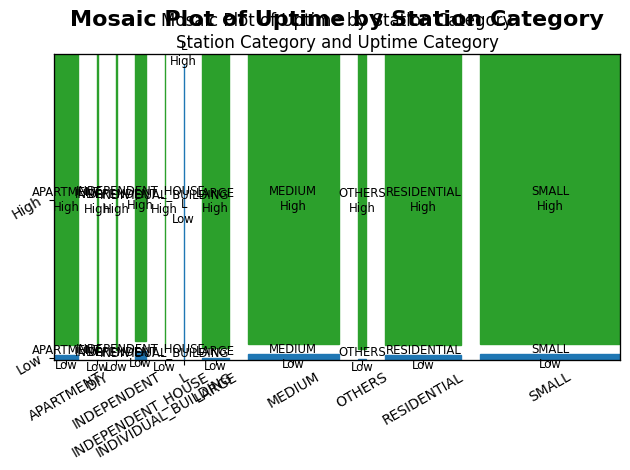

In [42]:
# Prepare data for the mosaic plot
uptime_data_simplified = data_cleaned.copy()

# Calculate average uptime and categorize into Low and High
uptime_data_simplified['Uptime'] = uptime_data_simplified[uptime_columns].mean(axis=1)
uptime_data_simplified['Uptime_Category'] = pd.cut(
    uptime_data_simplified['Uptime'], bins=[0, 0.5, 1], labels=['Low', 'High']
)

# Group data for the mosaic plot
data_for_mosaic = uptime_data_simplified.groupby(['Station_Category', 'Uptime_Category']).size()

# Convert to dictionary format required by mosaic
data_for_mosaic_dict = data_for_mosaic.to_dict()

# Create the Mosaic Plot
plt.figure(figsize=(14, 10))
mosaic(
    data_for_mosaic_dict,
    title="Mosaic Plot of Uptime by Station Category",
    label_rotation=30,
    gap=0.05,
    properties=lambda key: {'color': 'tab:blue' if key[1] == 'Low' else 'tab:green'},
)
plt.title('Mosaic Plot of Uptime by Station Category', fontsize=16, fontweight='bold')
plt.xlabel('Station Category and Uptime Category', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

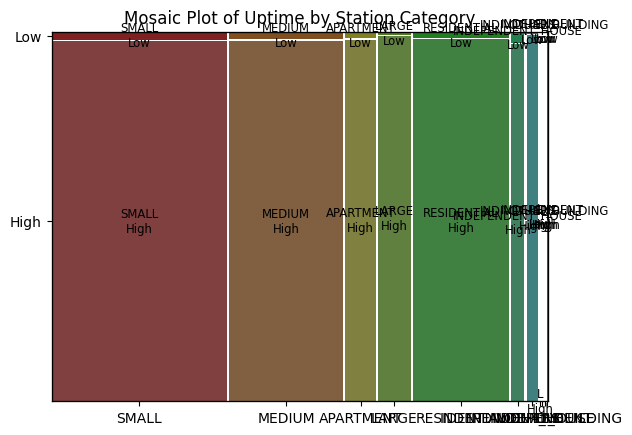

In [43]:
# Assuming 'data_cleaned' is your DataFrame
# Preparing a simplified version of the data for the mosaic plot
uptime_data_simplified = data_cleaned.copy()
uptime_data_simplified['Uptime'] = uptime_data_simplified[uptime_columns].mean(axis=1)
uptime_data_simplified['Uptime_Category'] = pd.cut(uptime_data_simplified['Uptime'], bins=[0, 0.5, 1], labels=['Low', 'High'])

# Creating the Mosaic Plot
plt.figure(figsize=(12, 8))
mosaic(uptime_data_simplified, ['Station_Category', 'Uptime_Category'])
plt.title('Mosaic Plot of Uptime by Station Category')
plt.show()


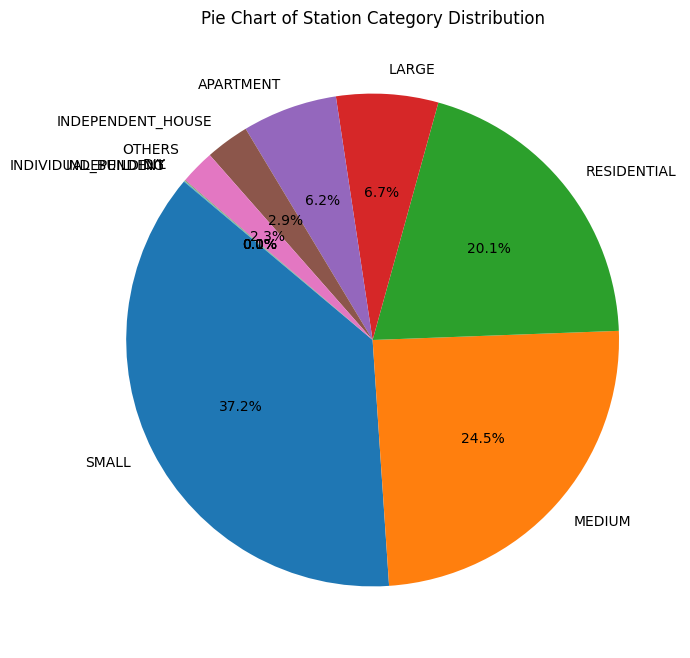

In [44]:
# Preparing data for Pie Chart
station_category_distribution = data_cleaned['Station_Category'].value_counts()

# Creating the Pie Chart
plt.figure(figsize=(10, 8))
station_category_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Station Category Distribution')
plt.ylabel('')  # Hide the y-label for clarity
plt.show()


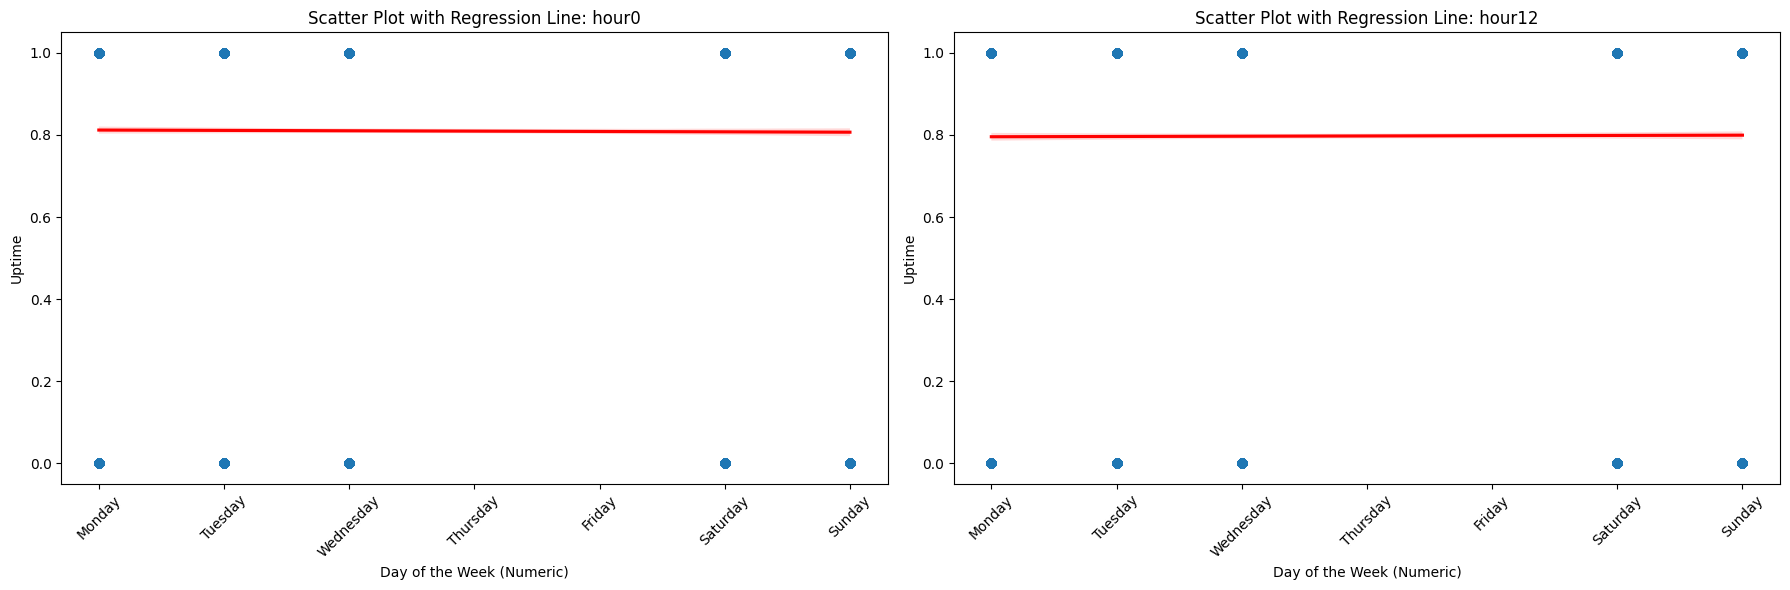

In [45]:
# Encoding the day of the week into numerical values
days_of_week = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
data_cleaned['DayOfWeekNumeric'] = data_cleaned['DayOfWeek'].map(days_of_week)

# Selecting a couple of hours for the scatter plot examples
selected_hours = ['hour0', 'hour12']  # Example: midnight and noon

# Creating scatter plots with regression lines
fig, ax = plt.subplots(1, len(selected_hours), figsize=(18, 6))

for i, hour in enumerate(selected_hours):
    sns.regplot(x='DayOfWeekNumeric', y=hour, data=data_cleaned, ax=ax[i], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    ax[i].set_title(f'Scatter Plot with Regression Line: {hour}')
    ax[i].set_xlabel('Day of the Week (Numeric)')
    ax[i].set_ylabel('Uptime')
    ax[i].set_xticks(np.arange(1, 8))
    ax[i].set_xticklabels(list(days_of_week.keys()), rotation=45)

plt.tight_layout()
plt.show()


In [46]:
# # Box Plot
# sns.boxplot(
#     x='Station_Category', y='Uptime', showmeans=True, linewidth=2, ax=ax[1], data=boxplot_data
# )
# ax[1].set_title('Box Plot of Uptime by Station Category')
# ax[1].set_xlabel('Station Category')
# ax[1].set_ylabel('Uptime')

# # Increasing the line width and showing means make the boxplot more visible
# # Adjust the y-axis limits if necessary to better visualize the boxplot
# # Rotate x-axis labels if necessary for better readability


# plt.tight_layout()
# plt.show()

In [47]:
# # Assuming 'data_cleaned', 'hourly_correlation', and 'uptime_columns' are available from previous code

# # Melting data for boxplot
# boxplot_data = data_cleaned.melt(id_vars=['Station_Category'], value_vars=uptime_columns, var_name='Hour', value_name='Uptime')

# # Plotting
# fig, ax = plt.subplots(2, 1, figsize=(15, 18))

# # Correlation Heatmap
# sns.heatmap(hourly_correlation, annot=True, cmap='coolwarm', ax=ax[0])
# ax[0].set_title('Correlation Heatmap of Uptime Between Different Hours')
# ax[0].set_xlabel('Hour of the Day')
# ax[0].set_ylabel('Hour of the Day')

# # Box Plot
# sns.boxplot(
#     x='Station_Category', y='Uptime', showmeans=True, linewidth=2, ax=ax[1], data=boxplot_data
# )
# ax[1].set_title('Box Plot of Uptime by Station Category')
# ax[1].set_xlabel('Station Category')
# ax[1].set_ylabel('Uptime')

# # Increasing the line width and showing means make the boxplot more visible
# # Adjust the y-axis limits if necessary to better visualize the boxplot
# # Rotate x-axis labels if necessary for better readability

# plt.tight_layout()
# plt.show()


In [48]:
# # Assuming 'data_cleaned', 'hourly_correlation', and 'uptime_columns' are available from previous code

# # Melting data for boxplot
# boxplot_data = data_cleaned.melt(id_vars=['Station_Category'], value_vars=uptime_columns, var_name='Hour', value_name='Uptime')

# # Plotting
# fig, ax = plt.subplots(2, 1, figsize=(15, 18))

# # Correlation Heatmap
# sns.heatmap(hourly_correlation, annot=True, cmap='coolwarm', ax=ax[0])
# ax[0].set_title('Correlation Heatmap of Uptime Between Different Hours')
# ax[0].set_xlabel('Hour of the Day')
# ax[0].set_ylabel('Hour of the Day')

# # Box Plot
# sns.boxplot(
#     x='Station_Category', y='Uptime', showmeans=True, linewidth=2, ax=ax[1], data=boxplot_data
# )
# ax[1].set_title('Box Plot of Uptime by Station Category')
# ax[1].set_xlabel('Station Category')
# ax[1].set_ylabel('Uptime')

# # Increasing the line width and showing means make the boxplot more visible
# # Adjust the y-axis limits if necessary to better visualize the boxplot
# # Rotate x-axis labels if necessary for better readability

# plt.tight_layout()
# plt.show()
